# Project 4
#### Aaron Otto, Ayan Khalif, Kirsten Rain, Ryan Cornelius


##### See readme




## Part 1 

#### Loads in a tab seperated dataset of new data. Data was found labelled from https://builtin.com/data-science/data-science-projects (link in number 3)
##### This file was initially a CSV in ANSI format, and was converted to a TSV in UTF-8 using notepad++.

In [1]:
# Import Libraries
# Libraries for data cleaning
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
import re 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Libraries for NN W2V model
import tensorflow as tf
from sklearn.metrics import accuracy_score,confusion_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import multiprocessing
import nltk
#from sklearn.pipeline import Pipeline

#
#Installing profiling lib (figured no one else would have this so doing pip incase)
#!pip install -U ydata-profiling
#!pip install ipywidgets
#from ydata_profiling import ProfileReport

# Turning Memory warnings off
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading Data File
df = pd.read_table("news-utf8.tsv", delimiter = '\t')


#Removing unecessary columns 
df =df[['key','title','text','label']]

#Dropping any blank rows picked up in excel load
df=df.dropna(how ='all')
df= df.dropna(subset=['text'])

#Formating Key column 
df['key'] = df['key'].astype(str).str.rstrip('0').str.rstrip('.')

#Sorting key column 
df=df.sort_values(by='key')

#Resetting index to correspond with key values asscending 
df= df.reset_index(drop=True)
df.head(5)

,key,title,text,label
0,1,Scalia’s death comes just a month before the c...,The unexpected death of Justice Antonin Scalia...,REAL
1,1,Rachel Dolezal's brother: She's 'making up mor...,(CNN) Ezra Dolezal would love to see his siste...,REAL
2,10001,What A Hillary Presidency Would Bring,"Behind the headlines - conspiracies, cover-ups...",FAKE
3,10004,Hillary Endorsed Donald Trump for President Ac...,Hillary Endorsed Donald Trump for President Ac...,FAKE
4,10006,US-led coalition killed 300 Syrian civilians i...,"RT October 26, 2016 \r\nAround 300 civilians w...",FAKE


In [3]:
Stop_list = list(ENGLISH_STOP_WORDS.copy())
Stop_list.extend(['s', 't', 'i', 'm', 'd', 'u', 've'])
Stop_list.extend(list(np.arange(0,10)))
Stop_list = set(Stop_list)
ENGLISH_STOP_WORDS = Stop_list

In [4]:
# Tokenize 'text' and 'title' columns and store the result
df['Words_Text'] = df['text'].apply(lambda x: re.findall(r'\b\w+\b', str(x).lower()))
df['Words_Title'] = df['title'].apply(lambda x: re.findall(r'\b\w+\b', str(x).lower()))
df.head()


,key,title,text,label,Words_Text,Words_Title
0,1,Scalia’s death comes just a month before the c...,The unexpected death of Justice Antonin Scalia...,REAL,"[the, unexpected, death, of, justice, antonin,...","[scalia, s, death, comes, just, a, month, befo..."
1,1,Rachel Dolezal's brother: She's 'making up mor...,(CNN) Ezra Dolezal would love to see his siste...,REAL,"[cnn, ezra, dolezal, would, love, to, see, his...","[rachel, dolezal, s, brother, she, s, making, ..."
2,10001,What A Hillary Presidency Would Bring,"Behind the headlines - conspiracies, cover-ups...",FAKE,"[behind, the, headlines, conspiracies, cover, ...","[what, a, hillary, presidency, would, bring]"
3,10004,Hillary Endorsed Donald Trump for President Ac...,Hillary Endorsed Donald Trump for President Ac...,FAKE,"[hillary, endorsed, donald, trump, for, presid...","[hillary, endorsed, donald, trump, for, presid..."
4,10006,US-led coalition killed 300 Syrian civilians i...,"RT October 26, 2016 \r\nAround 300 civilians w...",FAKE,"[rt, october, 26, 2016, around, 300, civilians...","[us, led, coalition, killed, 300, syrian, civi..."


In [5]:
# Define a function to remove stop words from a list of words and join them with commas
def process_words(words, stop_words):
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    return list(filtered_words)


In [6]:
# Remove stop words and join words with commas for 'Words_Text' and 'Words_Title' columns
df['Words_Text'] = df['Words_Text'].apply(lambda x: process_words(x, ENGLISH_STOP_WORDS))
df['Words_Title'] = df['Words_Title'].apply(lambda x: process_words(x, ENGLISH_STOP_WORDS))
df.drop(labels = ['title', 'text', 'key'], axis=1, inplace=True)


In [7]:
df.rename(columns = {'Words_Text': "text", 
                   'Words_Title': 'title'}, inplace = True) 

In [8]:
#df = pd.read_table("current/news_cleaned_utf8.tsv", delimiter = '\t')
#df.drop(columns=df.columns[0], axis=1,  inplace=True)
df['label'].replace({'REAL': True,
                     'FAKE' : False}, inplace = True)
df.head()

,label,text,title
0,True,"[unexpected, death, justice, antonin, scalia, ...","[scalia, death, comes, just, month, court, big..."
1,True,"[cnn, ezra, dolezal, love, sister, rachel, dna...","[rachel, dolezal, brother, making, lies]"
2,False,"[headlines, conspiracies, cover, ups, ancient,...","[hillary, presidency, bring]"
3,False,"[hillary, endorsed, donald, trump, president, ...","[hillary, endorsed, donald, trump, president, ..."
4,False,"[october, 2016, 300, civilians, killed, airstr...","[led, coalition, killed, 300, syrian, civilian..."


In [9]:
type(df['label'][0])

numpy.bool_

## Word2Vec Implementation

#### All setups here, file will be exported labelled with accuracy and number of epochs required
##### W2V Documentation used: 
https://radimrehurek.com/gensim/models/word2vec.html
##### Tutorials used: 
https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html#Gensim-Implementation

https://www.kaggle.com/code/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

https://intellipaat.com/blog/what-is-lstm/

https://intothedepthsofdataengineering.wordpress.com/2017/06/26/an-overview-of-word2vec/

##### As well as in-class materials. 


In [34]:
# W2V Model settings
source = 'text' #title or text, whether to run W2V on the article's title or bulk text
cores = 6 #Number of CPU cores
init_vectorsize = 150 #set the dimensions of the vectors used to represent the word set
window = 5 #Maximum distance between the current and predicted word within a sentence
min_count = 2 #Ignores all words with total frequency lower than this.
max_vocab_size = 50000000 #Every 10 million word types need about 1GB of RAM

train_epochs = 25 #number of times to iterate over dataset during training
w2v_epochs = train_epochs #number of times to iterate over dataset during W2V. Try to keep same size as train epochs
test_size = 0.2 #ratio to split test dataset during train, test split
max_vectorsize = 1000 #vectorsize padding to equalize final vectors

# NN settings, will be a sequential model with an embedding layer, optional LSTM layer, optional dense Layers, and an output layer.  
Layer2 = True
LSTM_units = 128 #LSTM layer units"

Layer3 = False
layer3Act = "relu" #Hidden layer 3 activation
hidden_nodes_layer3 = 512 #Hidden layer 3 node count

Layer4 = False
layer4Act = "relu" #Hidden layer 4 activation
hidden_nodes_layer4 = 128 #Hidden layer 4 node count

outputAct = "sigmoid" #Output layer activation


In [35]:
# Set data and labels
y = df['label']
X = df[source]

In [36]:
# Initialize and train the Word2Vec model
w2v_model = Word2Vec(sentences = X,
    vector_size=init_vectorsize,         # Size of word vectors
    window=window,                # Context window size
    min_count=min_count,             # Minimum word frequency
    workers=cores,           # Number of CPU cores to use
    epochs=w2v_epochs,                # Number of training epochs
    max_vocab_size=max_vocab_size
)

In [37]:
# Get the number of keys/words in the model
num_keys = len(w2v_model.wv.key_to_index)
num_keys

42773

In [38]:
# print(w2v_model.wv.key_to_index.keys()) # This will print all keys that made it into the model. Warning... This can be very long...
# print(X[0][:10]) # Check the first 10 word keys of article 1

In [39]:
# Set up tokenizer and transform X to numberical tokens. 
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

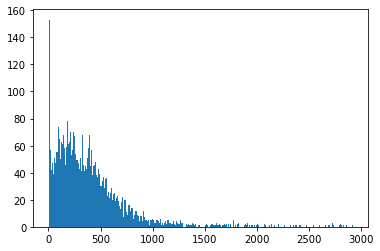

In [40]:
# Checking the length of all article's vectors and saving the distribution in a list.
vector_lengths = [len(x) for x in X]
plt.hist(vector_lengths, bins=500)
plt.show()

In [41]:
# Setting the W2V vectors to be all the same length, and if they are over the set max, truncates them. 
longest_vector = np.max(vector_lengths)
print(f'the longest vector is {longest_vector} words long')

if longest_vector >= max_vectorsize:
    longest_vector = max_vectorsize
    print(f'Max length is {longest_vector}, reducing and padding to {max_vectorsize} terms')

#Making all news of size maxlen defined above
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=longest_vector)

the longest vector is 2924 words long
Max length is 1000, reducing and padding to 1000 terms


In [42]:
# Setting up the training and testing split as per ratio above.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y)

In [43]:
# initializing the W2V model weight matrix to input into the NN initialization layer.
weight_matrix = w2v_model.wv.vectors

In [44]:
np.shape(weight_matrix)

(42773, 150)

In [45]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

nn = tf.keras.models.Sequential()
# First input hidden layer using model weight matrix, set to untrainable.
nn.add(tf.keras.layers.Embedding(num_keys, output_dim=init_vectorsize, weights=[weight_matrix], input_length=longest_vector, trainable=False))
# Second layer, using an LSTM layer that relies on the first weighted layer.
if Layer2 == True:
    nn.add(tf.keras.layers.LSTM(units=LSTM_units))
# Third hidden layer, a standard layer
if Layer3 == True:
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation=layer3Act))
# Fourth hidden layer, a standard layer
if Layer4 == True:
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation=layer4Act))
# Output layer, binary
nn.add(tf.keras.layers.Dense(units=1, activation=outputAct))

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
#del embedding_vectors

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 150)         6415950   
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,558,927
Trainable params: 142,977
Non-trainable params: 6,415,950
_________________________________________________________________


In [46]:
# Train the model, try/excepts used to select proper hardward device. 
if len(tf.config.list_physical_devices('GPU')) >= 1:
    try:
        print('Attempting to train model on GPU...')
        with tf.device('/GPU:0'):  #Note: I set up tensorflow with GPU. Change this to CPU:0 in order to obtain standard use. 
            fit_model = nn.fit(X_train,y_train,epochs=train_epochs)
    except:
        print('GPU error. Defaulting to use CPU.')
        with tf.device('/CPU:0'):  
            fit_model = nn.fit(X_train,y_train,epochs=train_epochs)
else:
    print('No GPU detected. Defaulting to use CPU.')
    with tf.device('/CPU:0'): 
        fit_model = nn.fit(X_train,y_train,epochs=train_epochs)

Attempting to train model on GPU...
Epoch 1/25
GPU error. Defaulting to use CPU.
Epoch 1/25
158/158 [==============================] - 95s 597ms/step - loss: 0.5098 - accuracy: 0.7376
Epoch 2/25
158/158 [==============================] - 95s 601ms/step - loss: 0.3933 - accuracy: 0.8280
Epoch 3/25
158/158 [==============================] - 95s 599ms/step - loss: 0.3122 - accuracy: 0.8665
Epoch 4/25
158/158 [==============================] - 95s 599ms/step - loss: 0.2738 - accuracy: 0.8969
Epoch 5/25
158/158 [==============================] - 95s 601ms/step - loss: 0.1573 - accuracy: 0.9458
Epoch 6/25
158/158 [==============================] - 97s 616ms/step - loss: 0.1084 - accuracy: 0.9654
Epoch 7/25
158/158 [==============================] - 98s 623ms/step - loss: 0.0668 - accuracy: 0.9831
Epoch 8/25
158/158 [==============================] - 99s 624ms/step - loss: 0.0323 - accuracy: 0.9938
Epoch 9/25
158/158 [==============================] - 99s 627ms/step - loss: 0.0473 - accuracy:

In [47]:
# Evaluate the model using the test data, try/excepts used to select proper hardward device.
if len(tf.config.list_physical_devices('GPU')) >= 1:
    try:
        print('Attempting to evaluate model on GPU...')
        with tf.device('/GPU:0'):  #Note: I set up tensorflow with GPU. Change this to CPU:0 in order to obtain standard use. 
            model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
            predictions = nn.predict(X_test)

    except:
        print('GPU error. Defaulting to use CPU.')
        with tf.device('/CPU:0'):  
            model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
            predictions = nn.predict(X_test)

else:
    print('No GPU detected. Defaulting to use CPU.')
    with tf.device('/CPU:0'): 
        model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
        predictions = nn.predict(X_test)
        
        
        
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Attempting to evaluate model on GPU...
GPU error. Defaulting to use CPU.
40/40 - 8s - loss: 0.9625 - accuracy: 0.8507 - 8s/epoch - 205ms/step
40/40 [==============================] - 8s 204ms/step
Loss: 0.9624575972557068, Accuracy: 0.8506751656532288


In [48]:
# Collecting the models confusion matrix
preds =  [np.round(x) % 2 == 0 for x in predictions]
cm = confusion_matrix(y_test, preds)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
# Displaying results
print("Confusion Matrix")
display(cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,96,529
Actual 1,542,92


In [49]:
# Export our model to HDF5 file using the data source, accuracy, and epochs as stratifiers. 
nn.save(f'models/Model_W2V_Project4_{source}_{model_accuracy:.2f}acc_{train_epochs}epochs.h5')

#### Extra links:
https://asistdl.onlinelibrary.wiley.com/doi/10.1002/pra2.2015.145052010082

https://sandipanweb.wordpress.com/2017/06/03/some-nlp-probabilistic-context-free-grammar-pcfg-and-cky-parsing/

https://gawron.sdsu.edu/compling/course_core/lectures/prob_parse.htm